# Installs & Imports

In [1]:
!pip install -q pyod prophet

In [2]:
# Data manipulation libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline

# Time series libraries
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA

# Machine learning libraries
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score

# PyOD libraries
from pyod.models.auto_encoder import AutoEncoder
from pyod.models.knn import KNN
from pyod.models.pca import PCA as PCA_OD

# Prophet library
from prophet import Prophet

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Load the Data

In [3]:
def data_loading_and_preprocessing():
    """
    Load the NYC Taxi dataset and preprocess it.
    """
    # Load the dataset
    url = 'https://raw.githubusercontent.com/numenta/NAB/master/data/realKnownCause/nyc_taxi.csv'
    df = pd.read_csv(url)

    # Convert timestamp to datetime
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Set timestamp as index
    df.set_index('timestamp', inplace=True)

    # Resample data to hourly frequency
    df = df.resample('H').sum()

    # Handle missing values
    df['value'].interpolate(method='time', inplace=True)

    return df

# Data Visualization

In [4]:
def data_visualization_and_summary(df):
    """
    Perform initial data visualization and statistical summarization.
    """
    # 1. Display first few rows
    print("First five rows of the dataset:")
    display(df.head())
    print("\n")

    # 2. Data types and missing values
    print("Data types and missing values:")
    print(df.info())
    print("\n")

    # 3. Statistical summary
    print("Statistical summary of the dataset:")
    display(df.describe())
    print("\n")

    # 4. Time Series Plot
    plt.figure(figsize=(15, 5))
    plt.plot(df.index, df['value'], label='Passenger Count')
    plt.title('NYC Taxi Passenger Counts Over Time')
    plt.xlabel('Timestamp')
    plt.ylabel('Passenger Count')
    plt.legend()
    plt.show()

    # 5. Histogram
    plt.figure(figsize=(10, 5))
    plt.hist(df['value'], bins=50, edgecolor='black')
    plt.title('Distribution of Passenger Counts')
    plt.xlabel('Passenger Count')
    plt.ylabel('Frequency')
    plt.show()

    # 6. Boxplot
    plt.figure(figsize=(8, 5))
    plt.boxplot(df['value'], vert=False)
    plt.title('Boxplot of Passenger Counts')
    plt.xlabel('Passenger Count')
    plt.show()

    # 7. Time Series Decomposition
    from statsmodels.tsa.seasonal import seasonal_decompose
    result = seasonal_decompose(df['value'], model='additive', period=24)
    result.plot()
    plt.show()

    # 8. Autocorrelation Plot
    from pandas.plotting import autocorrelation_plot
    plt.figure(figsize=(10, 5))
    autocorrelation_plot(df['value'])
    plt.title('Autocorrelation Plot')
    plt.show()

    # 9. Average Passenger Count by Hour
    df_reset = df.reset_index()
    df_reset['hour'] = df_reset['timestamp'].dt.hour
    hourly_avg = df_reset.groupby('hour')['value'].mean()
    plt.figure(figsize=(10, 5))
    hourly_avg.plot(kind='bar', color='skyblue', edgecolor='black')
    plt.title('Average Passenger Count by Hour')
    plt.xlabel('Hour of Day')
    plt.ylabel('Average Passenger Count')
    plt.xticks(rotation=0)
    plt.show()

    # 10. Average Passenger Count by Day of Week
    df_reset['day_of_week'] = df_reset['timestamp'].dt.day_name()
    daily_avg = df_reset.groupby('day_of_week')['value'].mean()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    daily_avg = daily_avg.reindex(days_order)
    plt.figure(figsize=(10, 5))
    daily_avg.plot(kind='bar', color='lightgreen', edgecolor='black')
    plt.title('Average Passenger Count by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Passenger Count')
    plt.xticks(rotation=45)
    plt.show()

    # 11. Rolling Statistics
    rolling_mean = df['value'].rolling(window=168).mean()
    rolling_std = df['value'].rolling(window=168).std()
    plt.figure(figsize=(15, 5))
    plt.plot(df['value'], label='Original', alpha=0.5)
    plt.plot(rolling_mean, color='red', label='Rolling Mean (168 hours)')
    plt.plot(rolling_std, color='black', label='Rolling Std Dev (168 hours)')
    plt.title('Rolling Mean & Standard Deviation (Weekly)')
    plt.xlabel('Timestamp')
    plt.ylabel('Passenger Count')
    plt.legend()
    plt.show()

# Feature Engineering

In [5]:
def feature_engineering(df):
    """
    Perform feature engineering on the dataset.
    """
    # Reset index to access timestamp
    df.reset_index(inplace=True)

    # Extract time-based features
    df['hour'] = df['timestamp'].dt.hour
    df['day_of_week'] = df['timestamp'].dt.dayofweek
    df['day'] = df['timestamp'].dt.day
    df['month'] = df['timestamp'].dt.month
    df['year'] = df['timestamp'].dt.year
    df['week_of_year'] = df['timestamp'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = df['day_of_week'].apply(lambda x: 1 if x >= 5 else 0)

    # Set timestamp as index again
    df.set_index('timestamp', inplace=True)

    # Create rolling statistics features
    df['rolling_mean_12'] = df['value'].rolling(window=12).mean()
    df['rolling_std_12'] = df['value'].rolling(window=12).std()
    df['rolling_mean_24'] = df['value'].rolling(window=24).mean()
    df['rolling_std_24'] = df['value'].rolling(window=24).std()
    df['rolling_mean_168'] = df['value'].rolling(window=168).mean()  # Weekly
    df['rolling_std_168'] = df['value'].rolling(window=168).std()

    # Create lag features
    df['lag_1'] = df['value'].shift(1)
    df['lag_2'] = df['value'].shift(2)
    df['lag_3'] = df['value'].shift(3)
    df['lag_24'] = df['value'].shift(24)
    df['lag_168'] = df['value'].shift(168)  # Same hour last week

    # Drop initial rows with NaN values due to lagging
    df.dropna(inplace=True)

    # One-hot encode categorical features
    df = pd.get_dummies(df, columns=['day_of_week'], prefix='dow', drop_first=True)
    df = pd.get_dummies(df, columns=['hour'], prefix='hour', drop_first=True)

    # List of features for modeling
    feature_cols = [
        'value', 'lag_1', 'lag_2', 'lag_3', 'lag_24', 'lag_168',
        'rolling_mean_12', 'rolling_std_12',
        'rolling_mean_24', 'rolling_std_24',
        'rolling_mean_168', 'rolling_std_168',
        'is_weekend', 'month', 'week_of_year'
    ] + [col for col in df.columns if 'dow_' in col or 'hour_' in col]

    # Prepare data for modeling
    X = df[feature_cols]

    return df, X

# Anomaly Detection

In [6]:
def stl_decomposition(df):
    """
    Perform STL decomposition and detect anomalies using Z-Score.
    """
    from scipy.stats import zscore

    # Apply STL decomposition
    stl = STL(df['value'], period=24)
    result = stl.fit()

    # Get residuals
    residual = result.resid

    # Compute Z-Scores
    z_scores = zscore(residual)

    # Detect anomalies using a fixed threshold
    threshold = 3
    labels = (np.abs(z_scores) > threshold).astype(int)

    return labels

In [7]:
def arima_residuals(df):
    """
    Fit ARIMA model and detect anomalies using residual analysis.
    """
    from scipy.stats import zscore

    # Fit ARIMA model
    model = ARIMA(df['value'], order=(5, 1, 0))
    model_fit = model.fit()

    # Get residuals
    residuals = model_fit.resid

    # Compute Z-Scores
    z_scores = zscore(residuals)

    # Detect anomalies using a fixed threshold
    threshold = 3
    labels = (np.abs(z_scores) > threshold).astype(int)

    return labels

In [8]:
def isolation_forest(X_scaled):
    """
    Apply Isolation Forest for anomaly detection.
    """
    # Initialize model
    model_if = IsolationForest(contamination=0.01, random_state=42)

    # Fit model and predict anomalies
    labels = model_if.fit_predict(X_scaled)
    labels = pd.Series(labels).map({1: 0, -1: 1})

    return labels

In [9]:
def local_outlier_factor(X_scaled):
    """
    Apply Local Outlier Factor for anomaly detection.
    """
    # Initialize model
    model_lof = LocalOutlierFactor(contamination=0.01)

    # Fit model and predict anomalies
    labels = model_lof.fit_predict(X_scaled)
    labels = pd.Series(labels).map({1: 0, -1: 1})

    return labels

In [10]:
def one_class_svm(X_scaled):
    """
    Apply One-Class SVM for anomaly detection.
    """
    # Initialize model
    model_ocsvm = OneClassSVM(nu=0.01, kernel="rbf", gamma=0.05)

    # Fit model and predict anomalies
    labels = model_ocsvm.fit_predict(X_scaled)
    labels = pd.Series(labels).map({1: 0, -1: 1})

    return labels

In [11]:
def autoencoder_method(X_scaled):
    """
    Apply AutoEncoder for anomaly detection.
    """
    # Initialize model
    model_ae = AutoEncoder(contamination=0.01, verbose=0)

    # Fit model and predict anomalies
    try:
        # If epochs and batch_size are accepted in fit method
        model_ae.fit(X_scaled, epochs=10, batch_size=32)
    except TypeError:
        # If not, fit without specifying epochs and batch_size
        model_ae.fit(X_scaled)

    labels = model_ae.labels_

    return labels

In [12]:
def knn_method(X_scaled):
    """
    Apply KNN for anomaly detection.
    """
    # Initialize model
    model_knn = KNN(contamination=0.01)

    # Fit model and predict anomalies
    model_knn.fit(X_scaled)
    labels = model_knn.labels_

    return labels

In [13]:
def pca_method(X_scaled):
    """
    Apply PCA for anomaly detection.
    """
    # Initialize model
    model_pca = PCA_OD(contamination=0.01)

    # Fit model and predict anomalies
    model_pca.fit(X_scaled)
    labels = model_pca.labels_

    return labels

In [14]:
def prophet_method(df):
    """
    Apply Prophet for anomaly detection.
    """
    # Prepare data for Prophet
    df_prophet = df.reset_index().rename(columns={'timestamp': 'ds', 'value': 'y'})

    # Initialize and fit the model
    model_prophet = Prophet(interval_width=0.95, daily_seasonality=True)
    model_prophet.fit(df_prophet[['ds', 'y']])

    # Create future dataframe
    future = model_prophet.make_future_dataframe(periods=0)

    # Forecast
    forecast = model_prophet.predict(future)

    # Merge forecast with original data
    df_prophet['yhat'] = forecast['yhat']
    df_prophet['yhat_upper'] = forecast['yhat_upper']
    df_prophet['yhat_lower'] = forecast['yhat_lower']

    # Detect anomalies
    df_prophet['anomaly'] = 0
    df_prophet.loc[df_prophet['y'] > df_prophet['yhat_upper'], 'anomaly'] = 1
    df_prophet.loc[df_prophet['y'] < df_prophet['yhat_lower'], 'anomaly'] = 1

    return df_prophet['anomaly']

# Model Evaluation

In [15]:
def create_ground_truth(df):
    """
    Create ground truth labels based on known anomaly periods.
    """
    # Known anomaly periods
    anomaly_dates = [
        ('2014-11-01', '2014-11-02'),  # NYC Marathon
        ('2014-11-27', '2014-11-28'),  # Thanksgiving
        ('2014-12-24', '2014-12-26'),  # Christmas
        ('2014-12-31', '2015-01-01'),  # New Year's Eve/Day
    ]

    # Initialize true anomaly column
    df['true_anomaly'] = 0

    # Mark anomalies in the dataset
    for start_date, end_date in anomaly_dates:
        df.loc[start_date:end_date, 'true_anomaly'] = 1

    return df['true_anomaly']

In [16]:
def evaluate_models(df, models):
    """
    Evaluate all models, print classification reports, and return a DataFrame of metrics.
    """
    metrics_dict = {'Model': [], 'Precision': [], 'Recall': [], 'F1-Score': []}
    for model_name, labels in models.items():
        precision = precision_score(df['true_anomaly'], labels, zero_division=0)
        recall = recall_score(df['true_anomaly'], labels, zero_division=0)
        f1 = f1_score(df['true_anomaly'], labels, zero_division=0)
        metrics_dict['Model'].append(model_name)
        metrics_dict['Precision'].append(precision)
        metrics_dict['Recall'].append(recall)
        metrics_dict['F1-Score'].append(f1)
        print(f"Classification Report for {model_name}:")
        print(classification_report(df['true_anomaly'], labels, zero_division=0))
        print("\n")
    metrics_df = pd.DataFrame(metrics_dict)
    return metrics_df

In [17]:
def plot_metrics(metrics_df):
    """
    Plot bar charts comparing precision, recall, and F1-score for each model.
    """
    metrics_df.set_index('Model', inplace=True)
    metrics_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Comparison of Model Metrics')
    plt.ylabel('Score')
    plt.xticks(rotation=45)
    plt.legend(loc='best')
    plt.show()

In [18]:
def plot_anomalies(df, models):
    """
    Plot anomalies detected by each method.
    """
    for model_name, labels in models.items():
        anomalies = df[labels == 1]
        plt.figure(figsize=(15, 5))
        plt.plot(df.index, df['value'], label='Passenger Count')
        plt.scatter(anomalies.index, anomalies['value'], color='red', label='Anomaly')
        plt.title(f"Anomalies Detected by {model_name}")
        plt.xlabel('Timestamp')
        plt.ylabel('Passenger Count')
        plt.legend()
        plt.show()

# Main Execution

In [19]:
def main():
    # Step 1: Data Loading and Preprocessing
    df = data_loading_and_preprocessing()

    # Step 2: Data Visualization and Statistical Summarization
    data_visualization_and_summary(df)
    print("\n")

    # Step 3: Feature Engineering
    df, X = feature_engineering(df)

    # Step 4: Create Ground Truth Labels
    df['true_anomaly'] = create_ground_truth(df)

    # Step 5: Scale Features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Step 6: Anomaly Detection Methods
    # Statsmodels Methods
    labels_stl = stl_decomposition(df)
    labels_arima = arima_residuals(df)

    # Sklearn Methods
    labels_if = isolation_forest(X_scaled)
    labels_lof = local_outlier_factor(X_scaled)
    labels_ocsvm = one_class_svm(X_scaled)

    # PyOD Methods
    labels_ae = autoencoder_method(X_scaled)
    labels_knn = knn_method(X_scaled)
    labels_pca = pca_method(X_scaled)

    # Prophet Method
    labels_prophet = prophet_method(df)

    # Assign labels to dataframe
    df['anomaly_stl'] = labels_stl
    df['anomaly_arima'] = labels_arima
    df['anomaly_if'] = labels_if.values
    df['anomaly_lof'] = labels_lof.values
    df['anomaly_ocsvm'] = labels_ocsvm.values
    df['anomaly_ae'] = labels_ae
    df['anomaly_knn'] = labels_knn
    df['anomaly_pca'] = labels_pca
    df['anomaly_prophet'] = labels_prophet.values

    # Step 7: Model Evaluation and Metrics Visualization
    models = {
        'STL Decomposition': df['anomaly_stl'],
        'ARIMA Residuals': df['anomaly_arima'],
        'Isolation Forest': df['anomaly_if'],
        'Local Outlier Factor': df['anomaly_lof'],
        'One-Class SVM': df['anomaly_ocsvm'],
        'AutoEncoder': df['anomaly_ae'],
        'KNN': df['anomaly_knn'],
        'PCA': df['anomaly_pca'],
        'Prophet': df['anomaly_prophet']
    }

    # Evaluate models and get metrics DataFrame
    print("\n")
    metrics_df = evaluate_models(df, models)

    # Plot metrics comparison
    plot_metrics(metrics_df)

    # Step 8: Visualizing Anomalies
    plot_anomalies(df, models)

First five rows of the dataset:


,value
timestamp,
2014-07-01 00:00:00,18971
2014-07-01 01:00:00,10866
2014-07-01 02:00:00,6693
2014-07-01 03:00:00,4433
2014-07-01 04:00:00,4379




Data types and missing values:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5160 entries, 2014-07-01 00:00:00 to 2015-01-31 23:00:00
Freq: h
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   value   5160 non-null   int64
dtypes: int64(1)
memory usage: 80.6 KB
None


Statistical summary of the dataset:


,value
count,5160.000000
mean,30275.138760
std,13759.780861
min,19.000000
25%,19095.750000
50%,33826.000000
75%,39282.250000
max,74409.000000


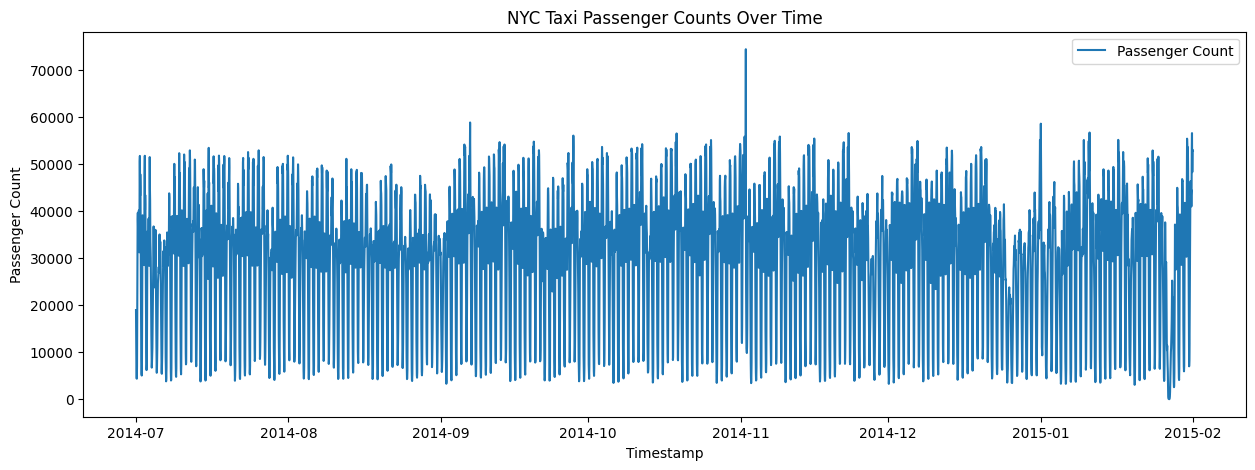

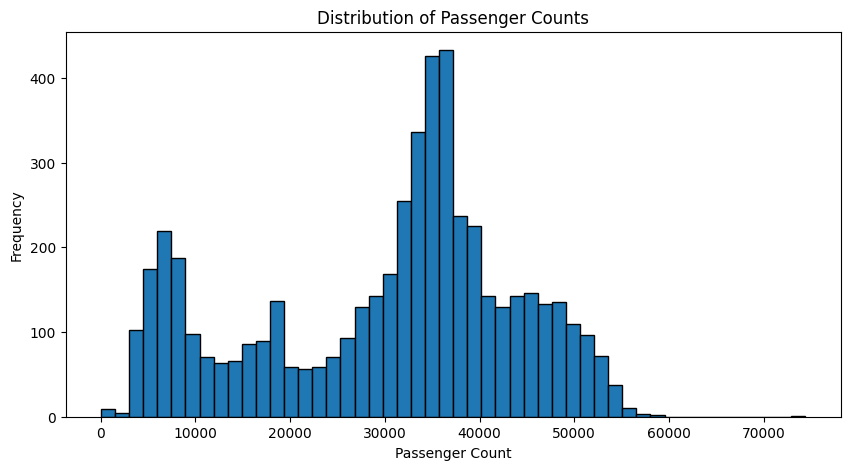

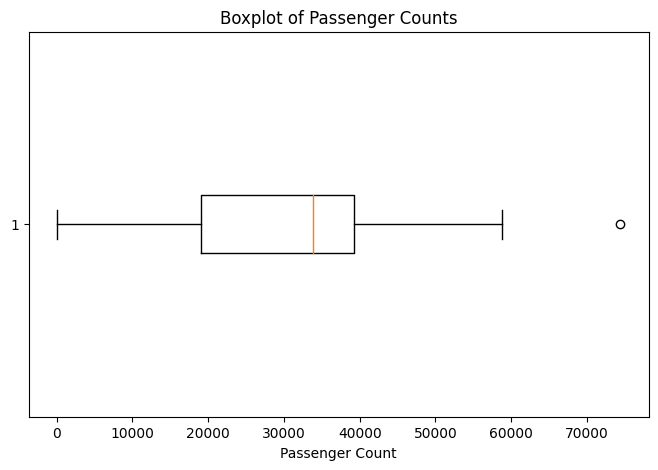

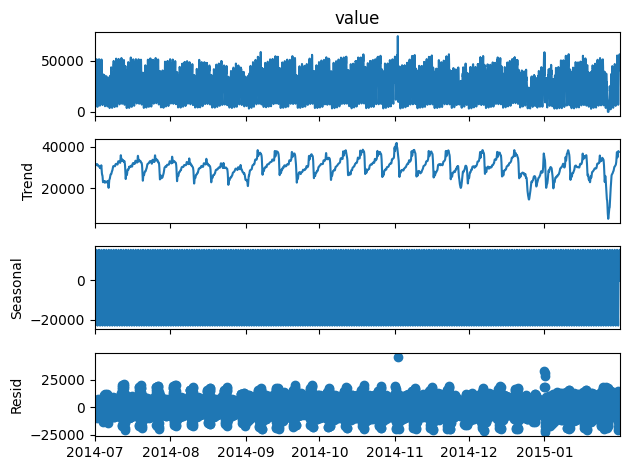

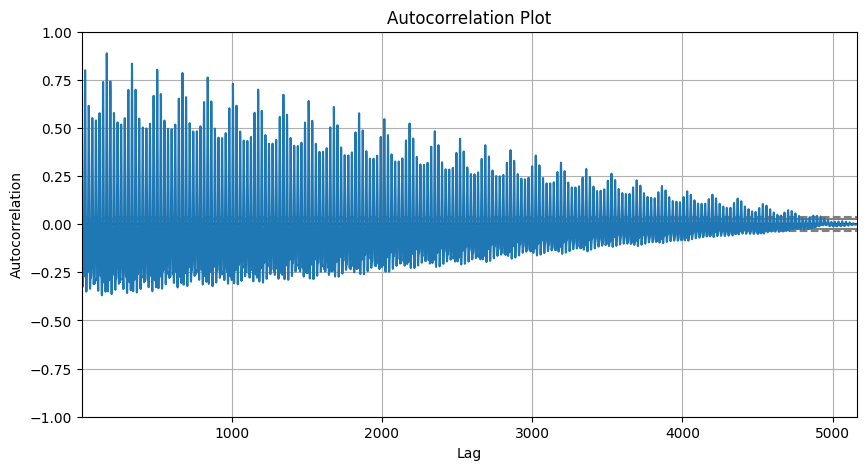

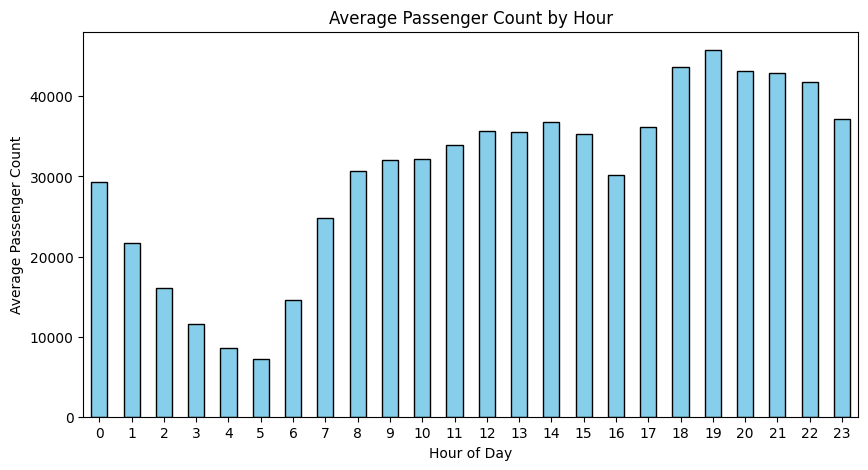

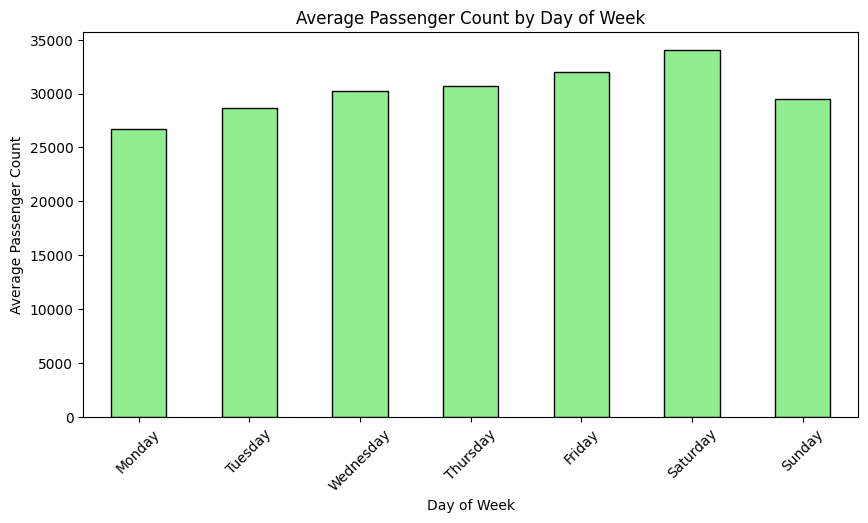

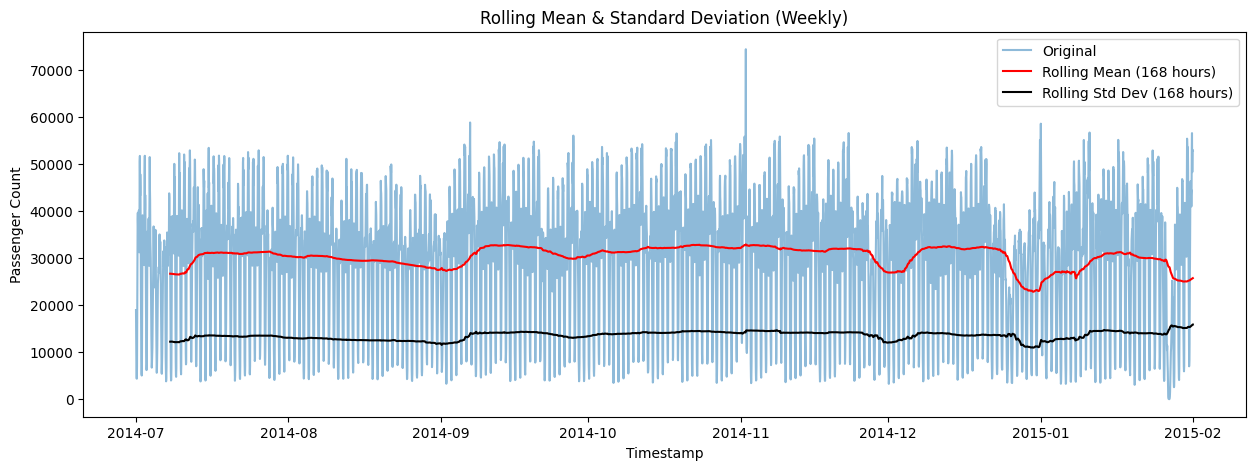

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmn0s_v84/uwepq6ut.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpmn0s_v84/_yn__j2x.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=72237', 'data', 'file=/tmp/tmpmn0s_v84/uwepq6ut.json', 'init=/tmp/tmpmn0s_v84/_yn__j2x.json', 'output', 'file=/tmp/tmpmn0s_v84/prophet_model68smjjy0/prophet_model-20241019060849.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:08:49 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:08:50 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing




Classification Report for STL Decomposition:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4776
           1       0.12      0.03      0.05       216

    accuracy                           0.95      4992
   macro avg       0.54      0.51      0.51      4992
weighted avg       0.92      0.95      0.93      4992



Classification Report for ARIMA Residuals:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4776
           1       0.11      0.03      0.05       216

    accuracy                           0.95      4992
   macro avg       0.53      0.51      0.51      4992
weighted avg       0.92      0.95      0.93      4992



Classification Report for Isolation Forest:
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      4776
           1       0.08      0.02      0.03       216

    accuracy                           0.95 

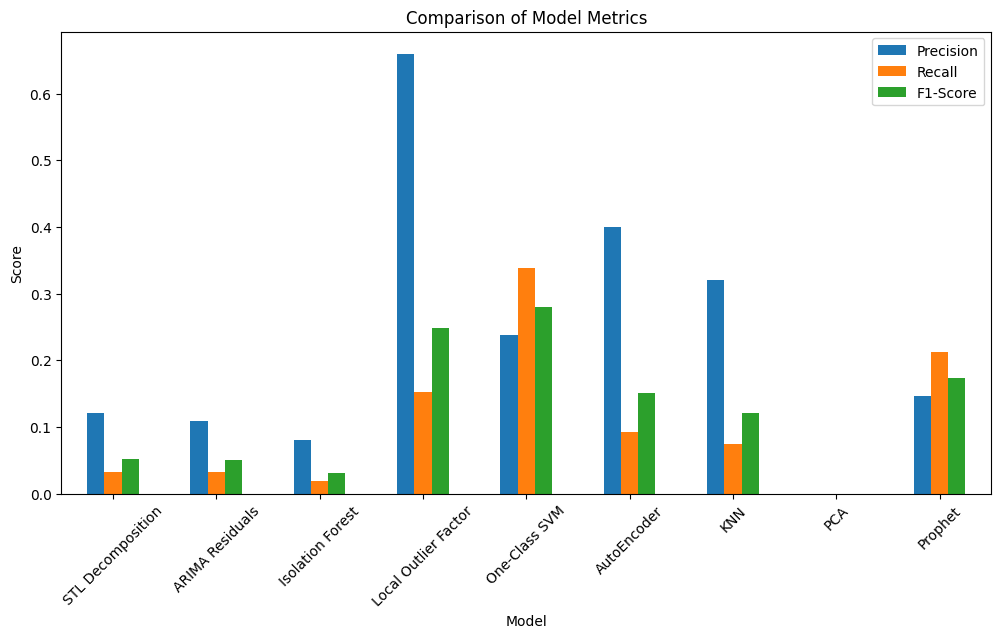

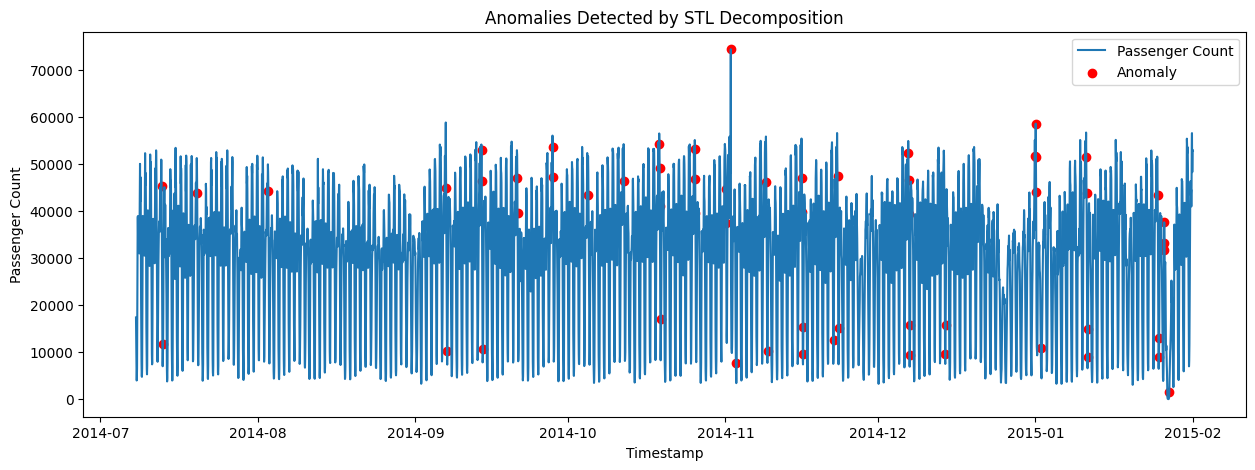

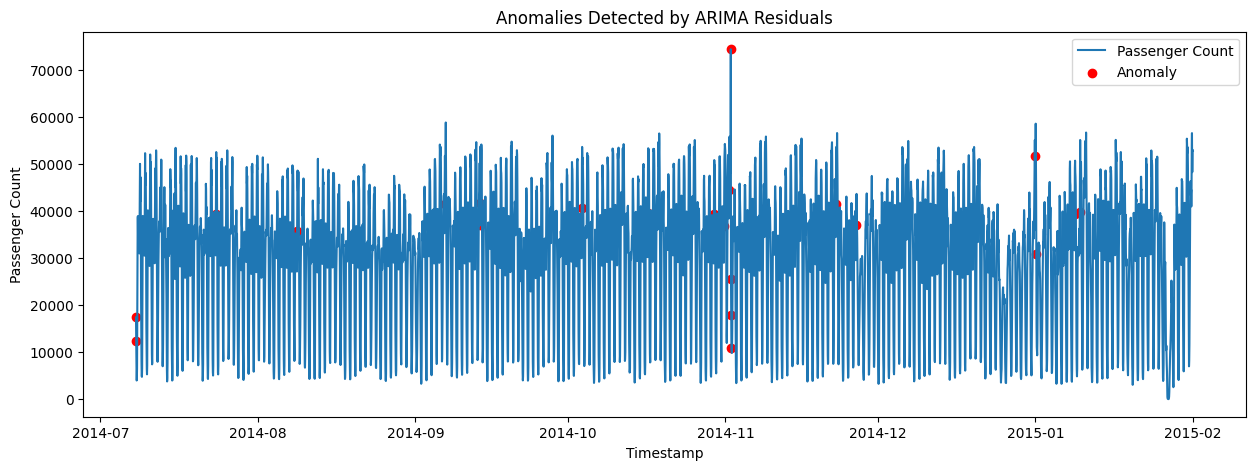

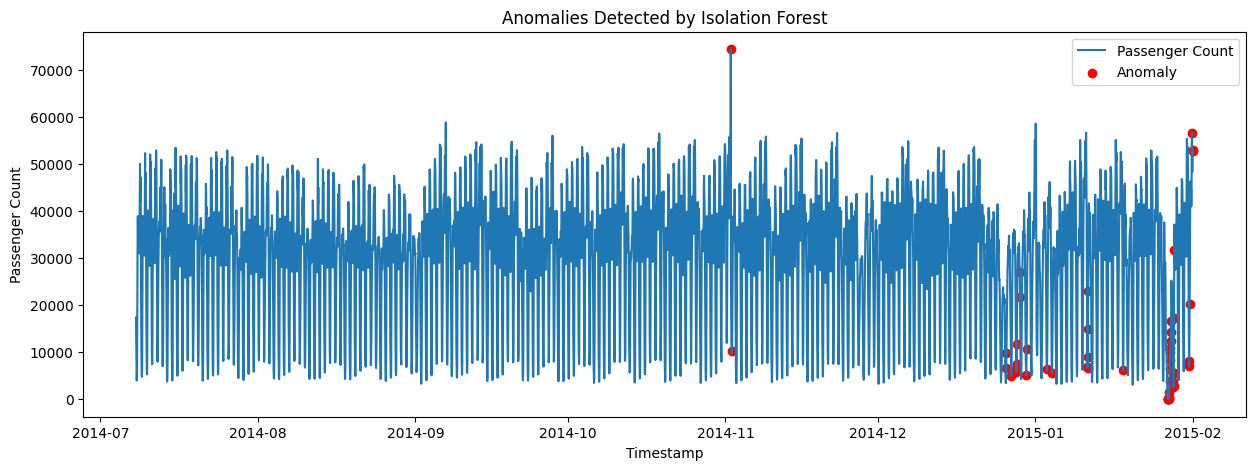

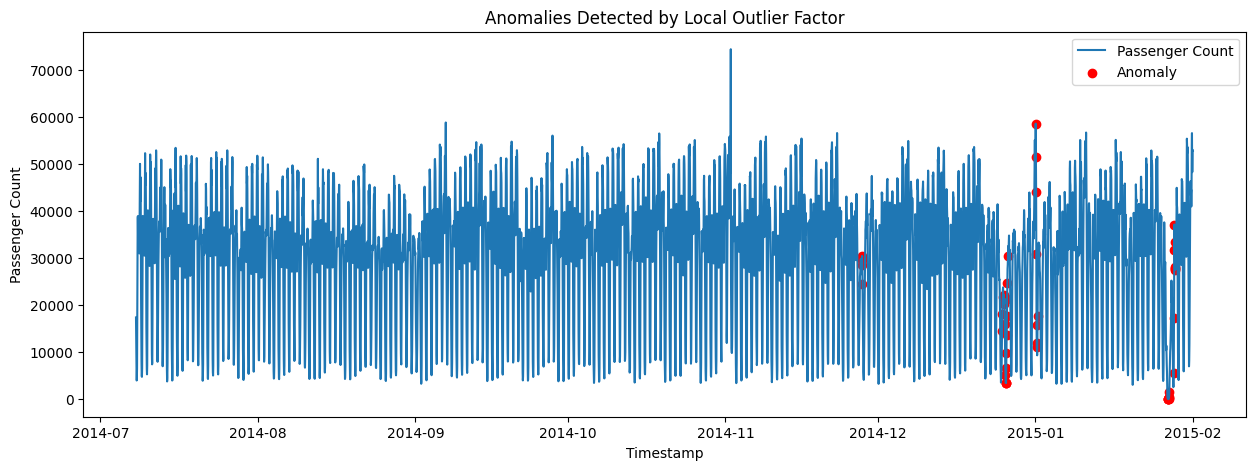

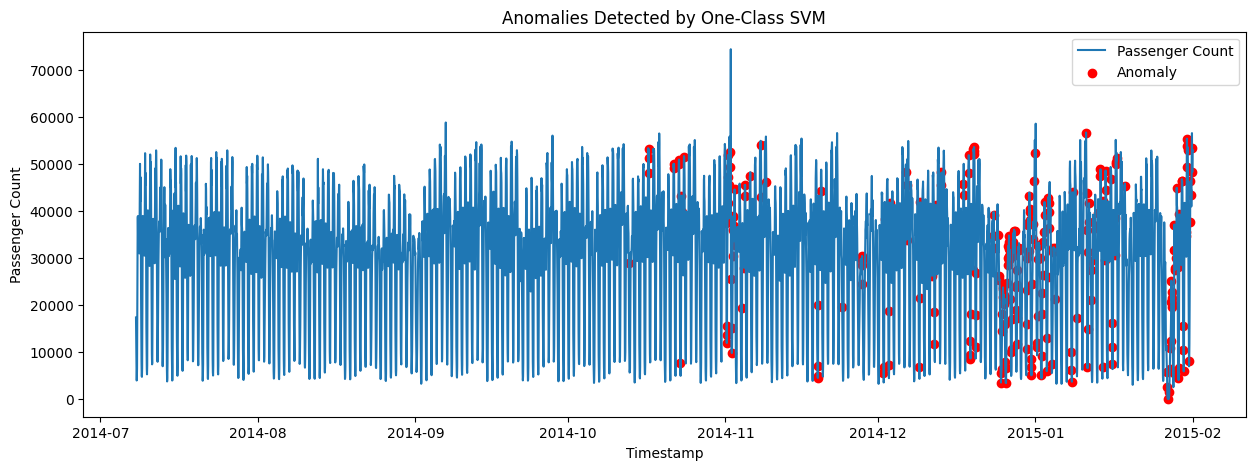

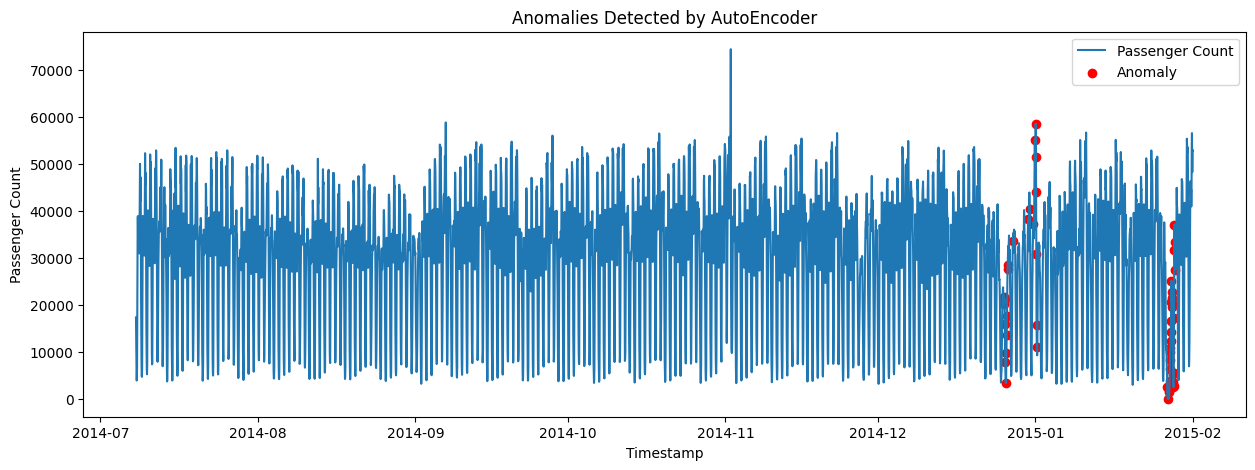

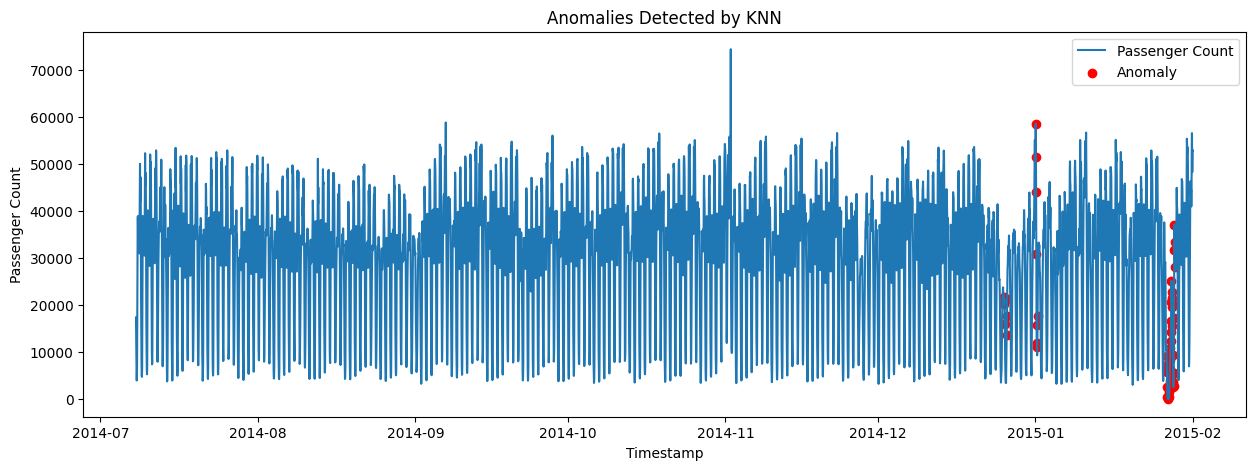

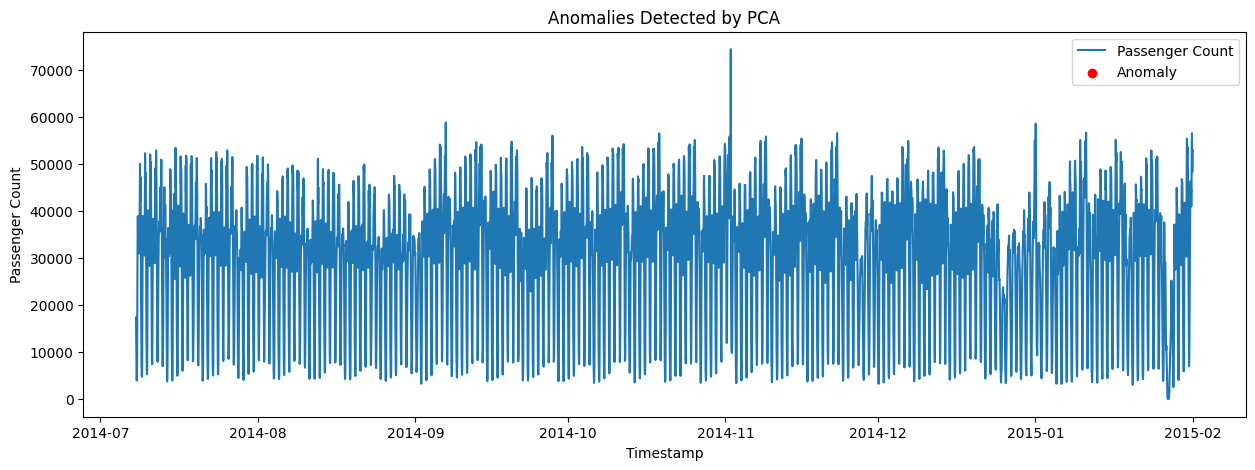

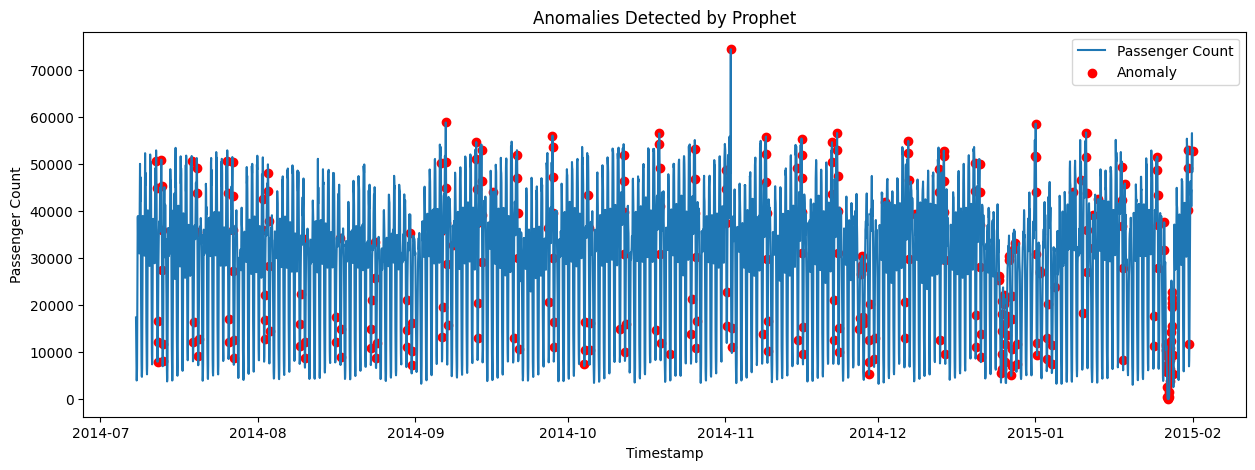

In [20]:
if __name__ == "__main__":
    main()